# Solving Helmholtz equation with PINNs

In [1]:
from jaxdf.core import operator, Field
from jaxdf.discretization import Coordinate
from jaxdf.geometry import Domain
from jaxdf import operators as jops

from matplotlib import pyplot as plt
from jax import numpy as jnp
import jax

First, define the Helmholtz operator with an absorbing PML layer around the domain

In [2]:
# Define domain and frequency
domain = Domain((1024, 1024), (.25, .25))
omega = .35

# Coordinate field
coordinate_discr = Coordinate(domain)
X = Field(coordinate_discr, params={}, name="X")

# Define PML Function
def sigma(x):
    alpha = 2.
    sigma_star = 1.
    delta_pml = 100.
    L_half = 128.
    
    abs_x = jnp.abs(x)
    in_pml_amplitude = (jnp.abs(abs_x-delta_pml)/(L_half - delta_pml))**alpha
    return jnp.where(abs_x > delta_pml, sigma_star*in_pml_amplitude, 0.)

# Helmholtz operator
@operator()
def helmholtz(u, c, x):
    # Building PML
    s = sigma(x)
    pml = 1./(1. + 1j*s/omega)
    
    # Laplacian with PML
    grad_u = jops.gradient(u)
    mod_grad_u = grad_u*pml
    mod_diag_jacobian = jops.diag_jacobian(mod_grad_u)*pml
    L = jops.sum_over_dims(mod_diag_jacobian)
    
    return L + ((omega/c)**2)*u

We represent the field as [Multiplicative Filter Networks](https://openreview.net/pdf?id=OmtmcPkkhT)

In [3]:
from jax.nn.initializers import glorot_normal, normal

def First(out_dim, W_init=glorot_normal()):
    
    def init_fun(rng, input_shape):
        keys = random.split(rng, 4)
        projected_shape = input_shape[:-1] + (out_dim,)
        omega = W_init(keys[2], (input_shape[-1], out_dim))
        phi =  normal()(keys[3], (out_dim,))
        
        output_shape = (projected_shape, input_shape)
        
        return output_shape, (omega, phi)
    
    def apply_fun(params, z, **kwargs):
        omega, phi = params
        freq = jnp.dot(z, omega)
        y = jnp.sin(freq + phi)
        return (y, z)
    
    return init_fun, apply_fun

def Middle(W_init=glorot_normal()):
    
    def init_fun(rng, input_shape):
        y_shape, z_shape = input_shape
        
        keys = random.split(rng, 4)
        
        W = W_init(keys[0], (y_shape[-1], y_shape[-1]))
        b = normal()(keys[1], (y_shape[-1],))
        omega = W_init(keys[2], (z_shape[-1], y_shape[-1]))
        phi =  normal()(keys[3], (y_shape[-1],))
        
        return input_shape, (W, omega, b, phi)
    
    def apply_fun(params, inputs, **kwargs):
        W, omega, b, phi = params
        y, z = inputs
        y = jnp.dot(y, W)+ b
        g = jnp.sin(jnp.dot(z, omega)+ phi)
        return (y*g, z)
    return init_fun, apply_fun
        
def Final(out_dim, C_init=glorot_normal(), b_init=normal()):
    def init_fun(rng, input_shape):
        y_shape, _ = input_shape
        output_shape = y_shape[:-1] + (out_dim,)
        
        k1, k2 = random.split(rng)
        C = C_init(k1, (y_shape[-1], out_dim))
        b = b_init(k2, (out_dim,))
        
        return output_shape, (C,b)
    
    def apply_fun(params, inputs, **kwargs):
        y, z = inputs
        C, b = params
        return jnp.dot(y, C) + b
    return init_fun, apply_fun

The following code defines the field representations used as input for the Helmholtz operator.

Note that the speed of sound has a circular inclusion of high value.

In [4]:
from jaxdf.discretization import Arbitrary, UniformField
from jax.example_libraries import stax
from jax import random

seed = random.PRNGKey(42)

# Make MFN
init_random_params, predict = stax.serial(
    First(256),
    Middle(),
    Middle(),
    Middle(),
    Middle(),
    Middle(),
    Middle(),
    Middle(),
    Final(2)
)

def init_params(seed, domain):
    return init_random_params(seed, (len(domain.N),))[1]

def get_fun(params, x):
    x = x
    p = predict(params, x)
    return jnp.asarray([p[0] + 1j*p[1]])

u_discr = Arbitrary(domain, get_fun, init_params)
u_params, u = u_discr.random_field(seed, name='u')

# Narrow gaussian pulse as source
def init_params(seed, domain):
    return {}

def gaussian_func(params, x):
    x = x + jnp.asarray([50,50])
    return jnp.expand_dims(jnp.exp(-jnp.sum(x**2)/8) + 0*1j, -1)

src_discr = Arbitrary(domain, gaussian_func, init_params)
src_params, src = src_discr.random_field(seed, name='src')

# Arbitrary Speed of Sound map
def init_params(seed, domain):
    return {}

def sos_func(params, x):
    x = x - jnp.asarray([32,32])
    x = jnp.exp(-jnp.sum(x**2)/2048)
    x = jnp.where(jnp.abs(x)>0.5, .5, 0.)
    return jnp.expand_dims(x + 1., -1)
                  
c_discr = Arbitrary(domain, sos_func, init_params)
c_params, c = c_discr.random_field(seed, name='c')

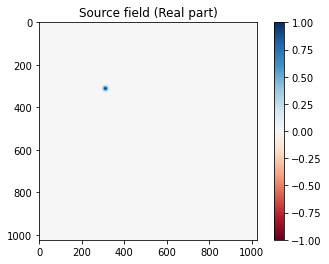

In [5]:
src_map = src_discr.get_field_on_grid()({})
plt.imshow(src_map.real, cmap="RdBu", vmax=1, vmin=-1)
plt.title("Source field (Real part)")
plt.colorbar()

In [6]:
# Build numerical operator and get parameters
Hu = helmholtz(u=u, c=c, x=X)
global_params = Hu.get_global_params()

In [7]:
from jax import value_and_grad

f = Hu.get_field(0)
def helmholtz_fun(params, x):
    return f(global_params,{"u": params, "c":c_params, "x":{}}, x)

# Defining losses
boundary_sampler = domain.boundary_sampler
domain_sampler = domain.domain_sampler
field = u_discr.get_field()
source_f = src.get_field()
def boundary_loss(params, seed, batchsize):
    x = boundary_sampler(seed, batchsize)
    field_val = jax.vmap(field, in_axes=(None,0))(params,x)
    r = jnp.abs(field_val)**2
    return jnp.sum(r)

def domain_loss(params, seed, batchsize):
    x = domain_sampler(seed, batchsize)
    helm_val = jax.vmap(helmholtz_fun, in_axes=(None,0))(params,x)
    src_val = jax.vmap(source_f, in_axes=(None,0))(None, x)
    r = jnp.abs(src_val + helm_val)**2
    return jnp.sum(r)

bound_valandgrad = value_and_grad(boundary_loss)
domain_valandgrad = value_and_grad(domain_loss)

In [8]:
# For logging 
import wandb

def log_image(wandb, field, name, step):
    plt.imshow(field[...,0].real, cmap='RdBu', vmax=0.5, vmin=-0.5)
    plt.colorbar()
    img = wandb.Image(plt)
    wandb.log({name: img}, step=step)
    plt.close()

In [9]:
# Training loop
from jax.example_libraries import optimizers
from jax.tree_util import tree_multimap
from jax import jit
from tqdm import tqdm

losshistory = []
batch_size = 2**10

init_fun, update_fun, get_params = optimizers.adam(.0001, 0.9, 0.99)
opt_state = init_fun(u_params)

def loss(params, seed):
    seeds = random.split(seed, 2)
    return 0.01*boundary_loss(params, seeds[0], batch_size) +  domain_loss(params, seeds[1], batch_size)

@jit
def update(opt_state, seed, k):
    params = get_params(opt_state)
    seeds = random.split(seed, 2)
    
    # losses
    boundary_loss, b_gradient = bound_valandgrad(params, seeds[0], batch_size)
    domain_loss, d_gradient = domain_valandgrad(params, seeds[1], batch_size)
    gradient = tree_multimap(lambda x,y: 0.01*x+y, b_gradient, d_gradient)
    
    return boundary_loss, domain_loss, update_fun(k, gradient, opt_state)

pbar = tqdm(range(100000))
tol = 1e-3
rng = seed

wandb.init(project="helmholtz-pinn")

boundary_loss_h = 0.
domain_loss_h = 0.
for k in pbar:
    rng, seed = random.split(rng,2)
    #seed=rng
    boundary_loss, domain_loss, opt_state = update(opt_state, seed, k)
    losshistory.append(domain_loss)

    # For logging
    boundary_loss_h = boundary_loss_h + boundary_loss
    domain_loss_h = domain_loss_h + domain_loss
    if (k+1) % 200 == 0:
        boundary_loss_h = boundary_loss_h / 200.
        domain_loss_h = domain_loss_h / 200.
        wandb.log({'boundary_loss': boundary_loss_h, 'domain_loss': domain_loss_h}, step=k)
        pbar.set_description("B: {:01.4f} | D: {:01.4f}".format(
            jnp.log10(boundary_loss), 
            jnp.log10(domain_loss)
        ))
        boundary_loss_h = 0.
        domain_loss_h = 0.
        
        # Logging image
        f_grid = u_discr.get_field_on_grid()
        V = f_grid(get_params(opt_state))
        log_image(wandb, V, "wavefield", k)


  0%|                                                                                                 | 0/100000 [00:00<?, ?it/s]wandb: Currently logged in as: rpfeynman (use `wandb login --relogin` to force relogin)
/home/antonio/anaconda3/envs/jwave/lib/python3.9/site-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


B: -2.7825 | D: -2.9820: 100%|███████████████████████████████████████████████████████████| 100000/100000 [28:10<00:00, 59.17it/s]


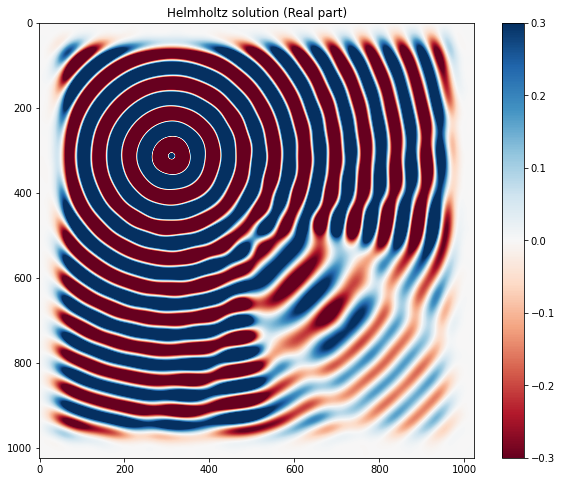

In [10]:
u_final = u_discr.get_field_on_grid()(get_params(opt_state))
plt.figure(figsize=(10,8))
plt.imshow(u_final[...,0].real, cmap='RdBu', vmax=.3, vmin=-.3)
plt.title("Helmholtz solution (Real part)")
plt.colorbar()

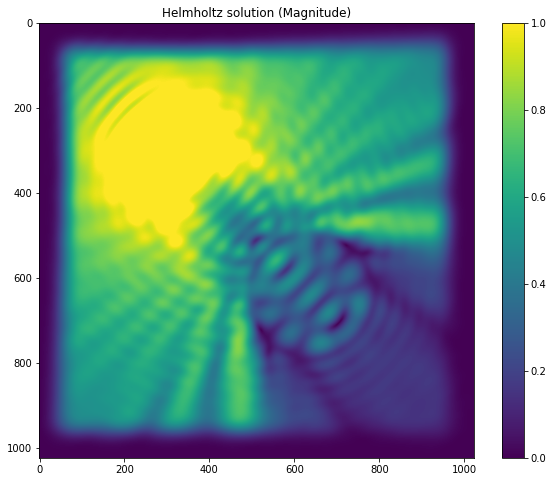

In [11]:
u_final = u_discr.get_field_on_grid()(get_params(opt_state))
plt.figure(figsize=(10,8))
plt.imshow(jnp.abs(u_final[...,0]), vmin=0, vmax=1)
plt.title("Helmholtz solution (Magnitude)")
plt.colorbar()